https://alexanderkurakin.blogspot.com/2018/12/pytorch-image-classifier.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████████████████████████████████████████████████████████▉| 170295296/170498071 [01:17<00:00, 2599890.31it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


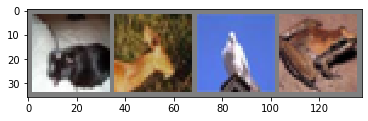

  cat  deer  bird  frog


In [13]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np

# функция для показа изображения

def imshow(img):
    img = img / 2 + 0.5     # денормализуем
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# получаем несколько случайных тренировочных изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

# показываем изображения
imshow(torchvision.utils.make_grid(images))
# печатаем метки
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
# -*- coding: utf-8 -*-

# проходим в цикле по набору данных несколько раз
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # получаем вводные данные
        inputs, labels = data

        # обнуляем параметр gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # печатаем статистику
        running_loss += loss.item()
        if i % 2000 == 1999:    # печатаем каждые 2000 мини-пакетов
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Тренировка завершена')

[1,  2000] loss: 2.200
[1,  4000] loss: 1.861
[1,  6000] loss: 1.680
[1,  8000] loss: 1.604
[1, 10000] loss: 1.511
[1, 12000] loss: 1.462
[2,  2000] loss: 1.428
[2,  4000] loss: 1.366
[2,  6000] loss: 1.333
[2,  8000] loss: 1.318
[2, 10000] loss: 1.308
[2, 12000] loss: 1.279
Тренировка завершена


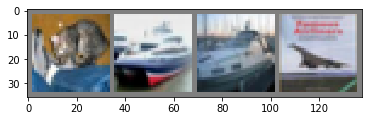

GroundTruth:    cat  ship  ship plane


In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# печатаем изображения
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', 
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [15]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


# Save

In [23]:
torch.save(net.state_dict(), 'net.pth')

# Load

In [19]:
net = Net()
net.load_state_dict(torch.load('net.pth'))
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# -*- coding: utf-8 -*-

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Аккуратность сети на 10000 тестовых изображений: %d %%' % (
    100 * correct / total))

Аккуратность сети на 10000 тестовых изображений: 54 %


In [22]:
# -*- coding: utf-8 -*-

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Аккуратность %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Аккуратность plane : 47 %
Аккуратность   car : 54 %
Аккуратность  bird : 48 %
Аккуратность   cat : 23 %
Аккуратность  deer : 47 %
Аккуратность   dog : 51 %
Аккуратность  frog : 57 %
Аккуратность horse : 75 %
Аккуратность  ship : 71 %
Аккуратность truck : 70 %


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Предполгаем, что у нас CUDA машина, 
# поэтому должно напечататься CUDA устройство:

print(device)

In [ ]:
net.to(device)

In [ ]:
inputs, labels = inputs.to(device), labels.to(device)